In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs_10nu import WMSE
from pitchfuncs_10nu import InversePCA
from pitchfuncs_10nu import emulator
from pitchfuncs_10nu import ns
import pandas as pd
import scipy
import numpy as np
import corner
import time

2024-03-26 18:07:44.169540: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 18:07:44.169568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 18:07:44.170401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 18:07:44.175168: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 18:07:44.680465: W tensorflow/compiler/tf2

In [2]:
"""
Load in grid
"""

df = pd.read_hdf('/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/bob.h5', key='df') #change if accessing from RDS

In [3]:
model = df
model = model[(model['star_age'] >= 4) & (model['star_age'] <= 6)]
model = model[(model['initial_mass'] >= 0.9) & (model['initial_mass'] <= 1.1)]
model = model[(model['initial_Yinit'] >= 0.28) & (model['initial_Yinit'] <= 0.3)]
model = model[(model['initial_Zinit'] >= 0.01) & (model['initial_Zinit'] <= 0.02)]
model = model[(model['initial_MLT'] >= 1.9) & (model['initial_MLT'] <= 2.1)]
model = model.sample(n=1)

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
outputs = ['radius', 'luminosity', 'surface_Z'] + [f'nu_0_{i+1}' for i in range(5,40)]

model_inps = model[inputs]
model_outs = model[outputs]

model

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,surface_Z,nu_0_4,...,log_nu_0_31_std,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std
5087549,1.06,0.012798,0.28,2.1,5.957655,1.421901,2.375533,6013.606464,0.010485,430.687874,...,-0.373412,-0.376796,-0.38157,-0.386126,-0.388569,-0.389043,-0.38834,-0.386811,-0.385218,-0.383359


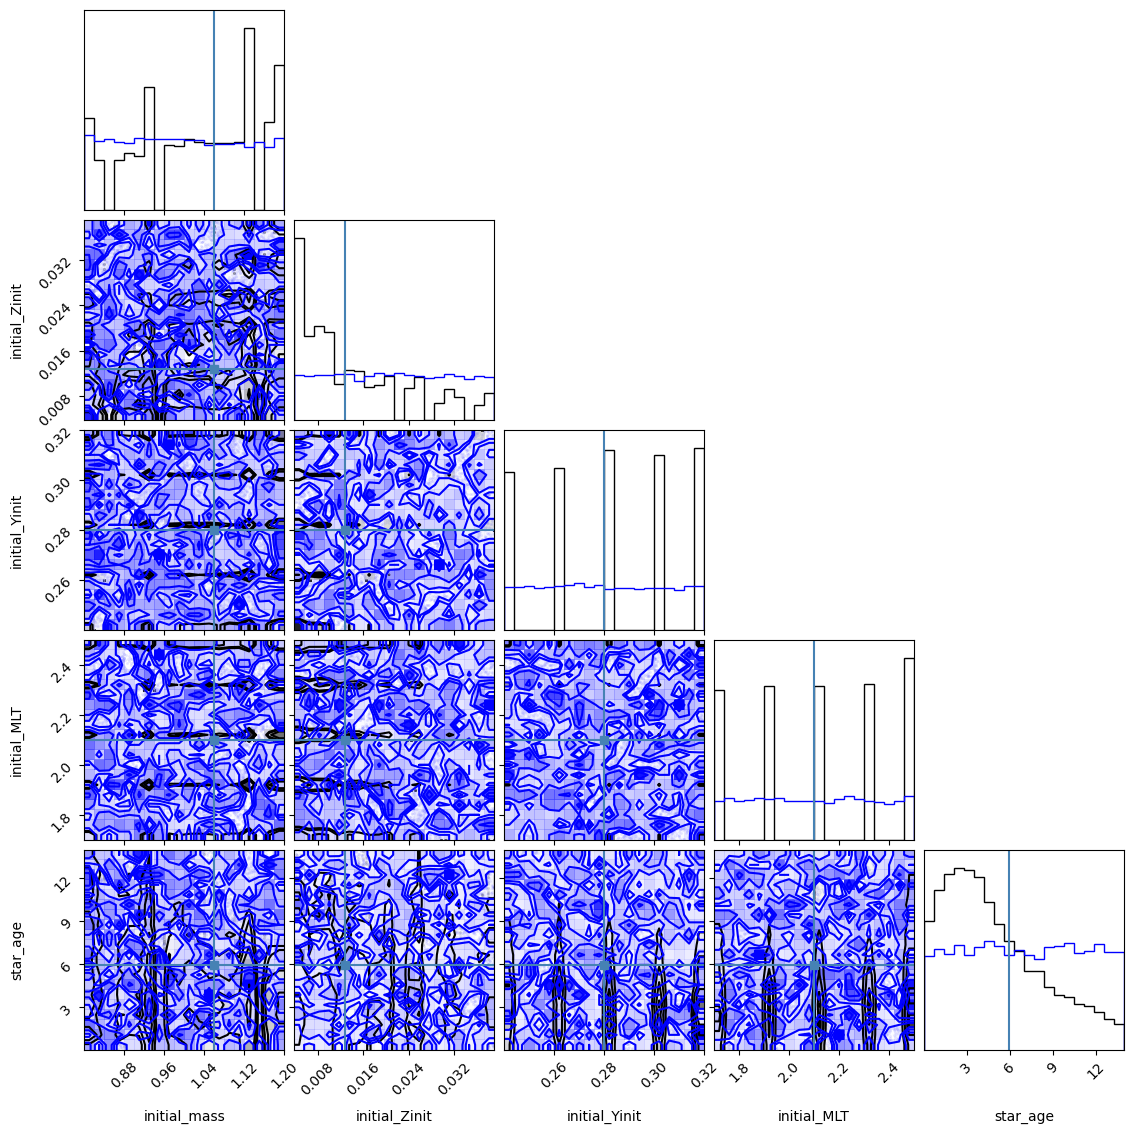

In [4]:
"""
Define priors
"""

def uniform_prior(model_inps, header):
    model_min = model_inps[header].min()
    return scipy.stats.uniform(loc=model_min, scale=model_inps[header].max()-model_min)

def normal_prior(model_inps, header, scale):
    return scipy.stats.norm(loc=model_inps[header], scale=scale)

mass_prior = uniform_prior(df, "initial_mass")

Zinit_prior = uniform_prior(df,"initial_Zinit")

Yinit_prior = uniform_prior(df, "initial_Yinit")

MLT_prior = uniform_prior(df, "initial_MLT")

age_prior = uniform_prior(df, "star_age")

priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

figure = corner.corner(df[inputs].sample(n=10000));

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure);

In [5]:
pitchfork = emulator("nu6-40_elu")

2024-03-26 18:07:50.858876: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-03-26 18:07:50.858896: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: Bia
2024-03-26 18:07:50.858901: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: Bia
2024-03-26 18:07:50.859024: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.161.7
2024-03-26 18:07:50.859043: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.161.7
2024-03-26 18:07:50.859047: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.161.7


initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


In [6]:
"""
Define observed quantities and uncertainties
"""
obs = pitchfork.predict(model_inps.values)
obs=np.concatenate((obs[:,:3],obs[:,15:25]),axis=1)

unc = [0.5, 1, 0.005] + [1.5+ 0.1*(np.abs(i-20))**2 for i in range(15,25)]

In [7]:
obs

array([[1.42263925e+00, 2.37499249e+00, 1.04944970e-02, 1.58668214e+03,
        1.66983067e+03, 1.75286386e+03, 1.83595125e+03, 1.91933233e+03,
        2.00299886e+03, 2.08688893e+03, 2.17091635e+03, 2.25467561e+03,
        2.33765592e+03]])

In [8]:
unc

[0.5, 1, 0.005, 4.0, 3.1, 2.4, 1.9, 1.6, 1.5, 1.6, 1.9, 2.4, 3.1]

In [ ]:
tic = time.time()
sampler = ns(priors=priors, observed_vals=obs, observed_unc=unc, pitchfork=pitchfork)
posterior = sampler(nlive=1000)
toc = time.time()

corner.corner(posterior);

1000


iter: 1144 | bound: 0 | nc: 3 | ncall: 3201 | eff(%): 35.739 | loglstar:   -inf < -545766.865 <    inf | logz: -545775.610 +/-  0.093 | dlogz: 546481.443 >  1.009                                    

117.03505873680115


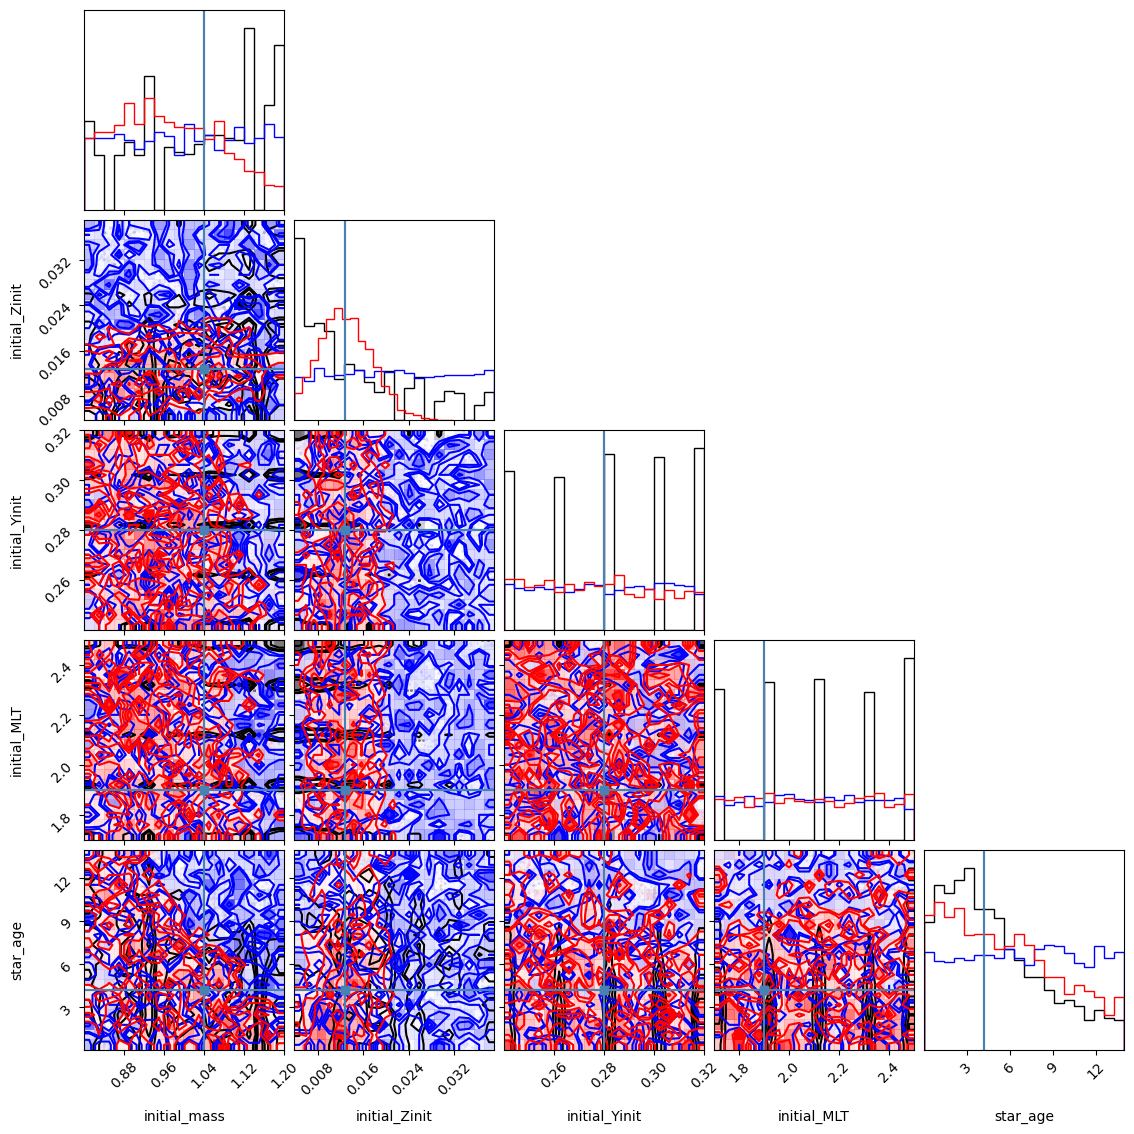

In [9]:
figure = corner.corner(df[inputs].sample(n=posterior.shape[0]));
print(toc-tic)
prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure);
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure);

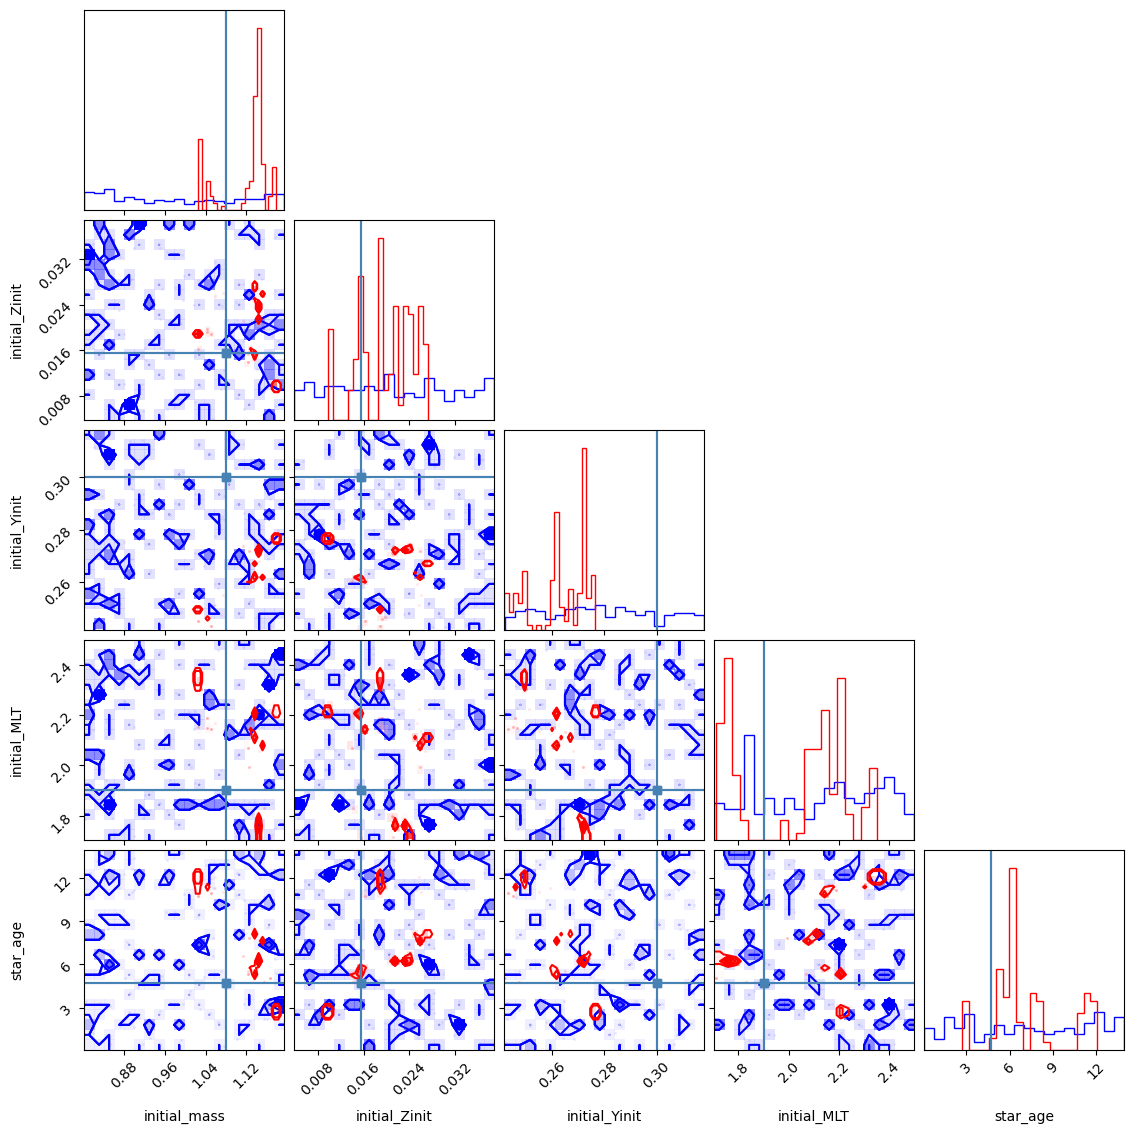

In [9]:
#prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True});
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure,hist_kwargs={'density':True});
#hist_kwargs={'density'=True}

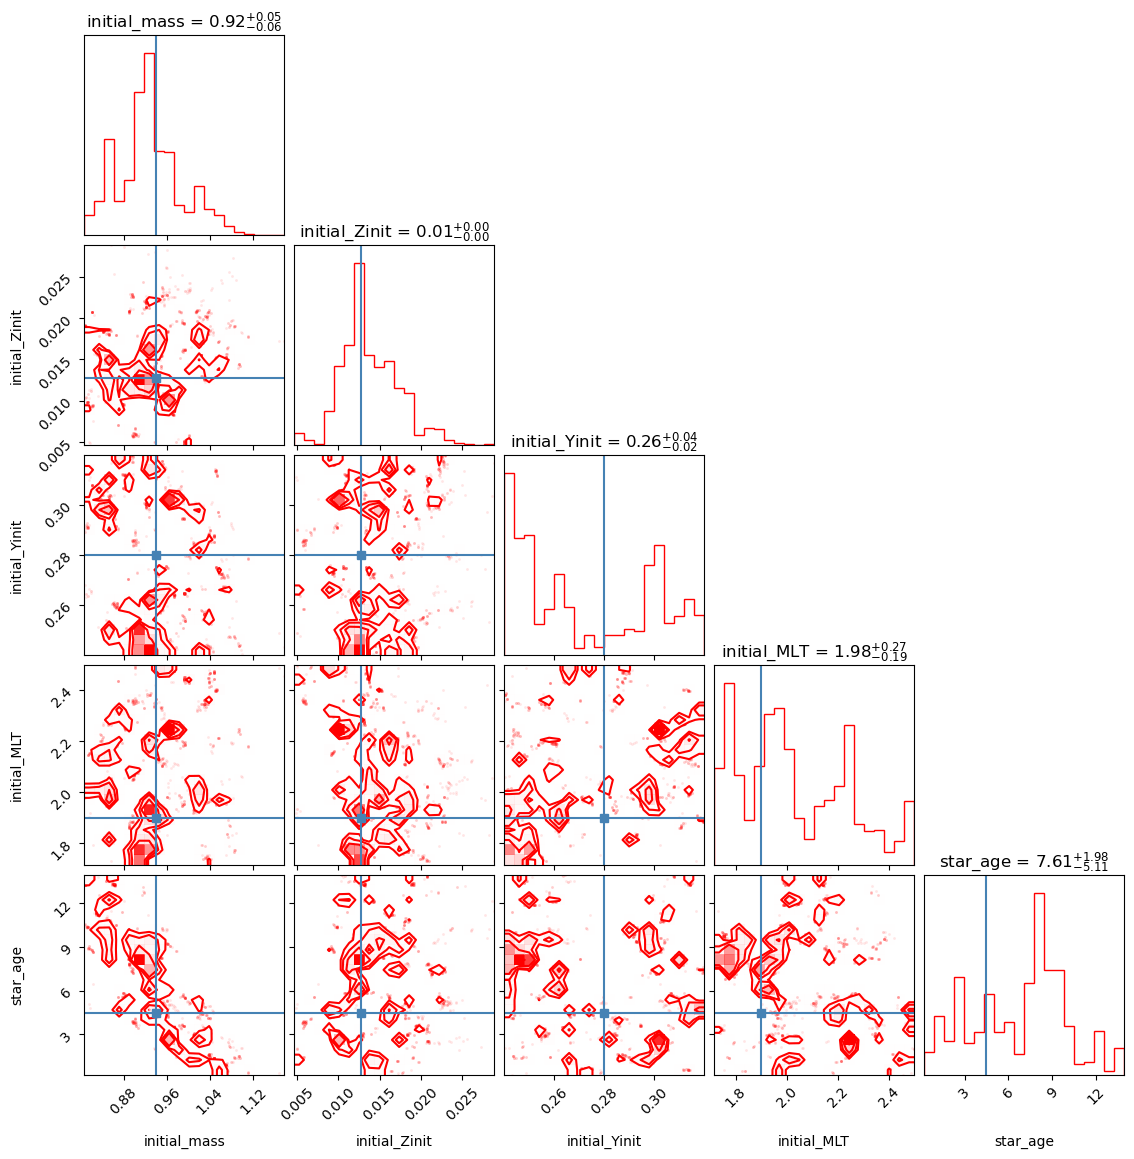

In [10]:
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True);

In [19]:
%timeit pitchfork.predict([[0,0,0,0,0]])

12.9 ms ± 47.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
import pickle
file_path = "pickle jar/nu6-40_elu"

with open(file_path+".pkl", 'rb') as fp:
    emulator_dict = pickle.load(fp)
    
custom_objects = {"InversePCA": InversePCA(emulator_dict['custom_objects']['inverse_pca']['pca_comps'], emulator_dict['custom_objects']['inverse_pca']['pca_mean']),"WMSE": WMSE(emulator_dict['custom_objects']['WMSE']['weights'])}

model = tf.keras.models.load_model(file_path+".h5", custom_objects=custom_objects)

In [18]:
%timeit model.predict([[0,0,0,0,0]])

1/1 [==============================] - 0s 21ms/step
44.4 ms ± 992 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
